In [3]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [5]:
#import tensorflow dpendencies
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input,Flatten
import tensorflow as tf


In [6]:
#GPu is not overloaded
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

Setting folders

In [5]:
os.makedirs('data/positive')
os.makedirs('data/negative')
os.makedirs('data/anchor')

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data/positive'

In [7]:
#uncompress Labelled Faces in the wild dataset
import tarfile

with tarfile.open('D:/facial recognition/lfw.tgz', 'r:gz') as tar:
    tar.extractall()


KeyboardInterrupt: 

In [ ]:
for directory in os.listdir('D:/facial recognition/lfw'):
    for file in os.listdir(os.path.join('D:/facial recognition/lfw', directory)):
        EX_PATH = os.path.join('D:/facial recognition/lfw', directory, file)
        NEW_PATH = os.path.join('D:/facial recognition/data/negative', file)
        os.replace(EX_PATH,NEW_PATH)


capturing anchor and positive

In [8]:
import uuid

cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame=frame[120:120+250,200:200+250, :]

    if(cv2.waitKey(1) & 0XFF == ord('a')):
        path = 'D:/facial recognition/data/anchor/' + str(uuid.uuid1()) + '.jpg'
        cv2.imwrite(path, frame)

    if(cv2.waitKey(1) & 0XFF == ord('p')):
        path = 'D:/facial recognition/data/positive/' + str(uuid.uuid1()) + '.jpg'
        cv2.imwrite(path, frame)c

    cv2.imshow('Image Collection', frame)
    if(cv2.waitKey(1) & 0XFF == ord('c')):
        break

cap.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 

In [8]:
#storing dataset
anc = tf.data.Dataset.list_files('D:/facial recognition/data/anchor/' + '*.jpg').take(300)
pos = tf.data.Dataset.list_files('D:/facial recognition/data/positive/' + '*.jpg').take(300)
neg = tf.data.Dataset.list_files('D:/facial recognition/data/negative/' + '*.jpg').take(300)

scalint between 0 and 1; and resizeing to 100*100*3 to optimize gradient descent

In [9]:
def optimal(path):
    byte_img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100,100)) 
    img = img / 255 
    return img
    


Creating dataset

In [10]:
positives = tf.data.Dataset.zip((anc, pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(anc)))))
negatives = tf.data.Dataset.zip((anc, neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anc)))))
data=positives.concatenate(negatives)

In [11]:
def preprocess(input_img, validation_img, label):
    return(optimal(input_img), optimal(validation_img), label)

In [12]:
#build dataloader pipeline
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [13]:
#training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
#to not bottle the neural network
train_data = train_data.prefetch(8)


In [14]:
#testing partition
test_data = data.skip(round(len(data)*.7))
train_data = data.take(round(len(data)*.3))
test_data = test_data.batch(16)
#to not bottle the neural network
test_data = test_data.prefetch(8)

In [15]:
#build embedding layer

def make_embedding():
    inp =  Input(shape=(100,100, 3), name='input_image')
    
    #first block
    con1 = Conv2D(64, (10,10), activation='relu')(inp)
    mp1 = MaxPooling2D(64, (2,2), padding='same')(con1)

    #second block
    con2 = Conv2D(128, (7,7), activation='relu')(mp1)
    mp2 = MaxPooling2D(64, (2,2), padding='same')(con2)
    
    #third block
    con3 = Conv2D(128, (4,4), activation='relu')(mp2)
    mp3 = MaxPooling2D(64, (2,2), padding='same')(con3)
    
    #final block
    con4 = Conv2D(256, (4,4), activation='relu')(mp3)
    f1 = Flatten()(con4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs= [d1], name='embedding')

embedding=make_embedding()

In [16]:
class L1Dist(Layer):
    
    def __init__(self, **kwargs):
        super().__init__()
       
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [17]:
l1 = L1Dist()

In [18]:
input_image = Input(name='input_img', shape=(100,100,3))
inp_embedding = embedding(input_image)

validation_image = Input(name='validation_img', shape=(100,100,3))
val_embedding = embedding(validation_image)

In [19]:
siamese_layer = L1Dist()
distances = siamese_layer(inp_embedding, val_embedding)
classifier = Dense(1, activation='sigmoid')(distances)

In [20]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [21]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [22]:
siamese_model = make_siamese_model()


Training

In [23]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [24]:
opt = tf.keras.optimizers.Adam(1e-4)

In [25]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        y = batch[2]
        
        # Add batch dimension to the input data
        X = [tf.expand_dims(x, axis=0) for x in X]
        
        yhat = siamese_model(X, training=True)
        
        # Remove the extra batch dimension from the logits
        yhat = tf.squeeze(yhat, axis=0)
        
        # Reshape y to have a shape of (1,)
        y = tf.reshape(y, (1,))
        
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    return loss



In [26]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)

In [27]:
EPOCHS = 8

In [27]:
train(train_data, EPOCHS)


 Epoch 1/8
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
180/180 [==============================] - 274s 2s/step

 Epoch 2/8
180/180 [==============================] - 282s 2s/step

 Epoch 3/8
180/180 [==============================] - 293s 2s/step

 Epoch 4/8
180/180 [==============================] - 740s 4s/step

 Epoch 5/8
180/180 [==============================] - 215s 1s/step

 Epoch 6/8
180/180 [==============================] - 212s 1s/step

 Epoch 7/8
180/180 [==============================] - 210s 1s/step

 Epoch 8/8
180/180 [==============================] - 210s 1s/step


In [28]:
from tensorflow.keras.metrics import Precision, Recall

In [29]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [30]:
y_hat = siamese_model.predict([test_input, test_val])

In [31]:
siamese_model.save('siamesemodel.h5')

In [32]:
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [33]:
model.predict([test_input, test_val])

array([[0.50225073],
       [0.5007642 ],
       [0.50052714],
       [0.5009333 ],
       [0.5001695 ],
       [0.50465375],
       [0.5030743 ],
       [0.50450945],
       [0.5007896 ],
       [0.50104326],
       [0.49999762],
       [0.49963176],
       [0.50246584],
       [0.503933  ],
       [0.5002776 ],
       [0.5036877 ]], dtype=float32)

In [34]:
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.8333333

In [35]:
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.35714287

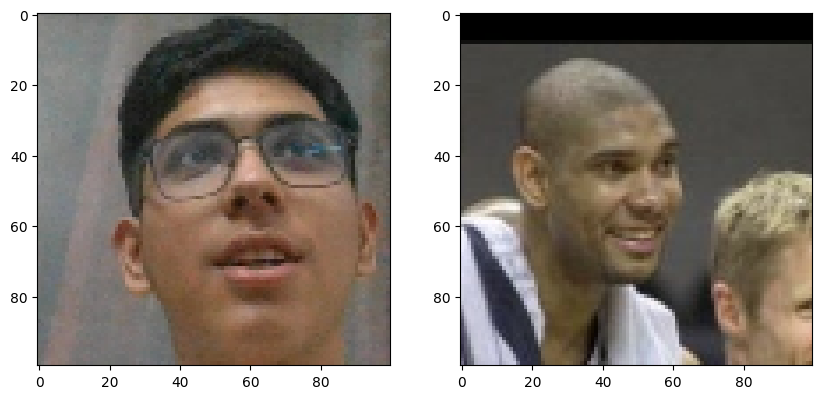

In [36]:
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

In [37]:
siamese_model.save('siamesemodel.h5')

In [38]:
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [39]:
model.predict([test_input, test_val])

array([[0.50225073],
       [0.5007642 ],
       [0.50052714],
       [0.5009333 ],
       [0.5001695 ],
       [0.50465375],
       [0.5030743 ],
       [0.50450945],
       [0.5007896 ],
       [0.50104326],
       [0.49999762],
       [0.49963176],
       [0.50246584],
       [0.503933  ],
       [0.5002776 ],
       [0.5036877 ]], dtype=float32)

In [40]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_4 (L1Dist)              (None, 4096)         0           embedding[0][0]     

In [44]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir('D:/facial recognition/application_data/verification_images'):
        input_img = optimal(os.path.join('D:/facial recognition/application_data/verification_images', 'input_image.jpg'))
        validation_img = optimal(os.path.join('D:/facial recognition/application_data/verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir('D:/facial recognition/application_data/verification_images')) 
    verified = verification > verification_threshold
    
    return results, verified

In [45]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('D:/facial recognition/application_data/input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('c'):
        break
cap.release()
cv2.destroyAllWindows()

NotFoundError: NewRandomAccessFile failed to Create/Open: D:/facial recognition/application_data/verification_images\input_image.jpg : The system cannot find the file specified.
; No such file or directory [Op:ReadFile]